Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [25]:
passengers = df['Passengers'].to_numpy(dtype='float32')

passengers

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [26]:
split_index = int(len(passengers) * 0.67)

train = passengers[:split_index]
test = passengers[split_index:]

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [27]:
import torch

def create_dataset(dataset: np.array, look_back_steps: int = 1):
    X, y = [], []

    for i in range(len(dataset) - look_back_steps):
        X.append(dataset[i: i + look_back_steps])
        y.append(dataset[i + look_back_steps])

    X = torch.tensor(np.array(X), dtype=torch.float32).view(-1, look_back_steps)
    y = torch.tensor(np.array(y), dtype=torch.float32).view(-1, 1)

    return X, y

In [28]:
look_back = 1  # more temporal context
X_train, y_train = create_dataset(train, look_back_steps=look_back)
X_test, y_test = create_dataset(test, look_back_steps=look_back)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні.
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [29]:
import torch.nn as nn

class AirModel(nn.Module):
	def __init__(self, hidden_size, num_layers):
		super(AirModel, self).__init__()

		self.hidden_size = hidden_size
		self.num_layers = num_layers

		# LSTM layer: input_size=1 since each timestamp has 1 feature (the passenger count)
		self.lstm = nn.LSTM(
			input_size=1,
			hidden_size=hidden_size,
			num_layers=num_layers,
			batch_first=True 			# shape will be (batch, seq_len, input_size)
		)

		# linear layer to map LSTM output to single prediction
		self.fc = nn.Linear(hidden_size, 1)
  
		# Add a dropout layer to your neural network in PyTorch, where:
		# 	•	0.2 means 20% of the neurons will be randomly set to zero during each forward pass only in training mode.
		# 	•	This is done to prevent overfitting, by ensuring the model does not rely too much on specific neurons.
		# What dropout does:
		# Imagine a neural network with hundreds of connections. 
  		# If the model becomes too good at fitting training data, it might memorize patterns that don’t generalize.
  		# Dropout randomly removes a portion of these connections each training step, forcing the model to learn redundant representations.
		# When is it used?
		# 	•	Only during model.train() (training mode).
		# 	•	Automatically disabled during evaluation (model.eval()), so predictions are stable.
		self.dropout = nn.Dropout(0.2)

	def forward(self, x):
		# LSTM expects input shape (batch_size, seq_len, input_size)
		out, _=self.lstm(x)				# we ignore hidden states (_)
		out = self.fc(out[:, -1, :]) 	# take output of the last timestamp
		return out

In [30]:
# Create model
model = AirModel(hidden_size=50, num_layers=1)

# Input tensor must be 3D: (batch_size, seq_len, input_size)
# Example input: passenger count 112
test_input = torch.tensor([[[112.0]]], dtype=torch.float32)

# Foward pass
with torch.no_grad():
	output = model(test_input)		 # Get prediction from model without tracking gradients

print("Model output:", output.item())

Model output: 0.06060761958360672


**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [31]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train.unsqueeze(1), y_train) 
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

# Optional: Inspect a Sample Batch
for xb, yb, in train_dl:
    print("x batch:", xb)
    print("y batch:", yb)
    break

x batch: tensor([[[242.]],

        [[405.]],

        [[141.]],

        [[235.]],

        [[148.]],

        [[114.]],

        [[264.]],

        [[121.]]])
y batch: tensor([[233.],
        [355.],
        [135.],
        [227.],
        [148.],
        [140.],
        [272.],
        [135.]])


**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [32]:
import torch.optim as optim
from math import sqrt 

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses=[]

# training loop
num_epochs = 2000
	
for epoch in range(num_epochs):
	model.train()
	total_loss = 0
    
	for xb, yb in train_dl:
		optimizer.zero_grad()			# Clear gradients
		output = model(xb)				# Forward pass
		loss = loss_fn(output, yb)		# Compute MSE loss
		loss.backward()					# Backward pass (compute gradients)
		optimizer.step()				# Update weights
		total_loss += loss.item()		# Accumulate loss
    
	avg_loss = total_loss / len(train_dl)
	losses.append(avg_loss)
    
	if epoch % 100 == 0:
		model.eval()
  
		with torch.no_grad():
			train_pred = model(X_train.unsqueeze(1))
			test_pred = model(X_test.unsqueeze(1))
			train_rmse = sqrt(loss_fn(train_pred, y_train).item())
			test_rmse = sqrt(loss_fn(test_pred, y_test).item())
		print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

Epoch 0: train RMSE 223.8001, test RMSE 420.1310
Epoch 100: train RMSE 74.3365, test RMSE 235.3337
Epoch 200: train RMSE 71.1779, test RMSE 216.9963
Epoch 300: train RMSE 71.1519, test RMSE 215.6989
Epoch 400: train RMSE 71.1491, test RMSE 215.1311
Epoch 500: train RMSE 71.1491, test RMSE 215.1344
Epoch 600: train RMSE 71.1491, test RMSE 215.1047
Epoch 700: train RMSE 71.1491, test RMSE 215.1359
Epoch 800: train RMSE 71.1491, test RMSE 215.1861
Epoch 900: train RMSE 71.1491, test RMSE 215.0405
Epoch 1000: train RMSE 71.1491, test RMSE 215.1134
Epoch 1100: train RMSE 71.1496, test RMSE 214.8535
Epoch 1200: train RMSE 71.1492, test RMSE 214.9819
Epoch 1300: train RMSE 71.1494, test RMSE 214.9181
Epoch 1400: train RMSE 71.1496, test RMSE 214.8668
Epoch 1500: train RMSE 71.1492, test RMSE 214.9942
Epoch 1600: train RMSE 71.1498, test RMSE 215.4091
Epoch 1700: train RMSE 71.1500, test RMSE 215.4385
Epoch 1800: train RMSE 71.1496, test RMSE 215.3471
Epoch 1900: train RMSE 71.1494, test RMSE 

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

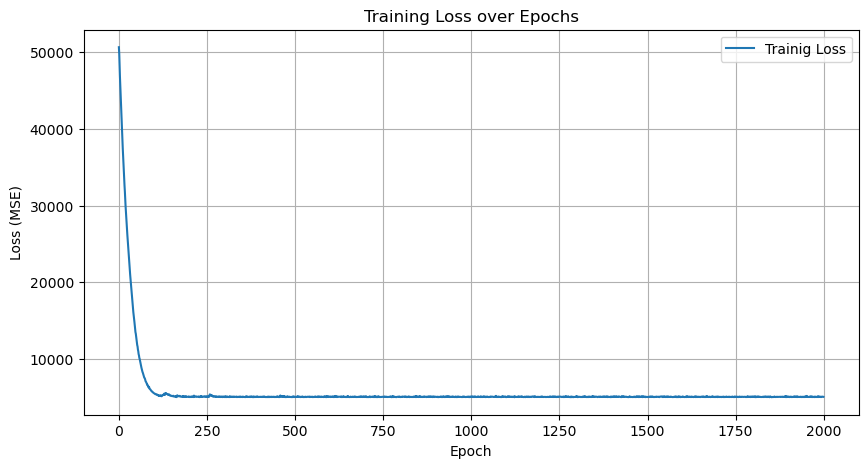

In [33]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 5))
plt.plot(losses, label="Trainig Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

As I can see, model has finished it's training and RMS has not dropped significantly. 
Besides that, model has got onto the plato after about 200 epochs. 
It says that model can be overfitted as it has learned all training data, but cannot generalize correctly.

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

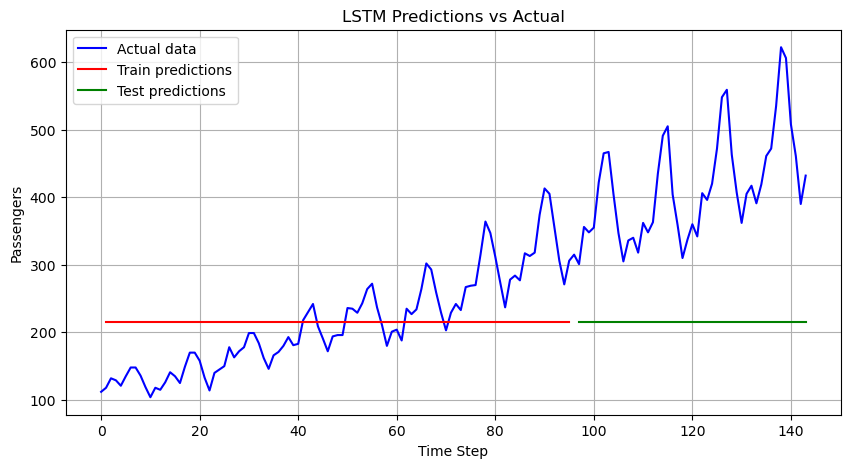

In [34]:
# def plot_predicts():
#   with torch.no_grad():
#       # Зсув прогнозів для тренувальних даних
#       train_plot = np.ones_like(timeseries) * np.nan
#       y_pred = model(X_train)
#       y_pred = y_pred[:, -1]
#       train_plot[lookback:train_size] = model(X_train)[:, -1]

#       # Зсув прогнозів для тестових даних
#       test_plot = np.ones_like(timeseries) * np.nan
#       test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

#   # Візуалізація результатів
#   plt.plot(timeseries, c='b')  # Реальні дані
#   plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
#   plt.plot(test_plot, c='g')   # Прогнози на тестових даних
#   plt.show()

def plot_predicts(model):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
         # Prepare placeholders
        train_plot = np.full_like(passengers, np.nan)
        test_plot = np.full_like(passengers, np.nan)
        
        # Predict on training data
        y_pred_train = model(X_train.view(-1, look_back, 1))
        train_plot[look_back:look_back + len(y_pred_train)] = y_pred_train.squeeze().numpy()

        # Predict on test data
        y_pred_test = model(X_test.view(-1, look_back, 1))
        test_plot[len(train) + look_back:len(passengers)] = y_pred_test.squeeze().numpy()
        
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(passengers, label="Actual data", color="blue")
    plt.plot(train_plot, label="Train predictions", color="red")
    plt.plot(test_plot, label="Test predictions", color="green")
    plt.legend()
    plt.title("LSTM Predictions vs Actual")
    plt.xlabel("Time Step")
    plt.ylabel("Passengers")
    plt.grid(True)
    plt.show()
        
plot_predicts(model)

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

Epoch 0: train RMSE 221.2450, test RMSE 417.5429
Epoch 100: train RMSE 72.2003, test RMSE 226.6104
Epoch 200: train RMSE 71.5688, test RMSE 222.3469
Epoch 300: train RMSE 71.1828, test RMSE 217.1520
Epoch 400: train RMSE 71.9726, test RMSE 225.2729
Epoch 500: train RMSE 71.1493, test RMSE 215.2707
Epoch 600: train RMSE 71.2589, test RMSE 218.8006
Epoch 700: train RMSE 71.1510, test RMSE 214.6219
Epoch 800: train RMSE 71.1496, test RMSE 214.8431
Epoch 900: train RMSE 71.1493, test RMSE 215.2638
Epoch 1000: train RMSE 71.1493, test RMSE 214.9287
Epoch 1100: train RMSE 71.1508, test RMSE 215.5706
Epoch 1200: train RMSE 71.1491, test RMSE 215.0547
Epoch 1300: train RMSE 71.1491, test RMSE 215.1628
Epoch 1400: train RMSE 71.1491, test RMSE 215.1683
Epoch 1500: train RMSE 71.1497, test RMSE 215.3823
Epoch 1600: train RMSE 71.1510, test RMSE 214.6158
Epoch 1700: train RMSE 71.1492, test RMSE 215.1946
Epoch 1800: train RMSE 71.1491, test RMSE 215.0604
Epoch 1900: train RMSE 71.1495, test RMSE 

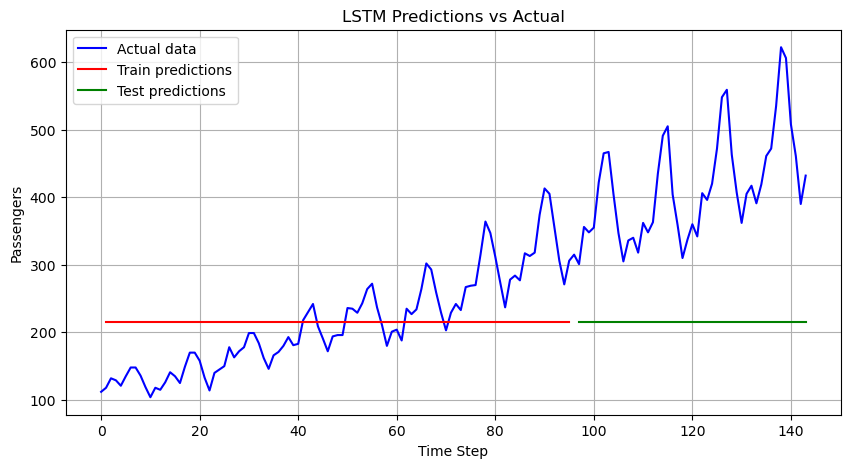

In [38]:
model = AirModel(hidden_size=100, num_layers=1)

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

losses=[]

# training loop
num_epochs = 2000
	
for epoch in range(num_epochs):
	model.train()
	total_loss = 0
    
	for xb, yb in train_dl:
		optimizer.zero_grad()			# Clear gradients
		output = model(xb)				# Forward pass
		loss = loss_fn(output, yb)		# Compute MSE loss
		loss.backward()					# Backward pass (compute gradients)
		optimizer.step()				# Update weights
		total_loss += loss.item()		# Accumulate loss
    
	avg_loss = total_loss / len(train_dl)
	losses.append(avg_loss)
    
	if epoch % 100 == 0:
		model.eval()
  
		with torch.no_grad():
			train_pred = model(X_train.unsqueeze(1))
			test_pred = model(X_test.unsqueeze(1))
			train_rmse = sqrt(loss_fn(train_pred, y_train).item())
			test_rmse = sqrt(loss_fn(test_pred, y_test).item())
		print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")
  
plot_predicts(model)

I cannot see any difference between this model and model with 50 hidden layers. 
So it makes no difference if we use 50 or 100 hidden layers.